# Laboratorio di simulazioni numeriche
### Esercizio 7.1

Date le seguenti configurazioni:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off: $r_c = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off: $r_c = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off: $r_c = 5.0$)

viene richiesto di utilizzare il codice di Monte Carlo NVT fornito per campionare $M=5*10^5$ valori istantanei di pressione $P$ e energia potenziale per particella $U/N$ nelle tre fasi. Questi dati devono essere utilizzati per ettenere grafici delle funzioni di autocorrelazione al fine di stabilire la lunghezza minima dei blocchi per avere medie indipendenti nel blocking method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
u_g = np.loadtxt("Lab7/output.epot.gas.0")
u_l = np.loadtxt("Lab7/output.epot.liquid.0")
u_s = np.loadtxt("Lab7/output.epot.solid.0")
p_g = np.loadtxt("Lab7/output.pres.gas.0")
p_l = np.loadtxt("Lab7/output.pres.liquid.0")
p_s = np.loadtxt("Lab7/output.pres.solid.0")

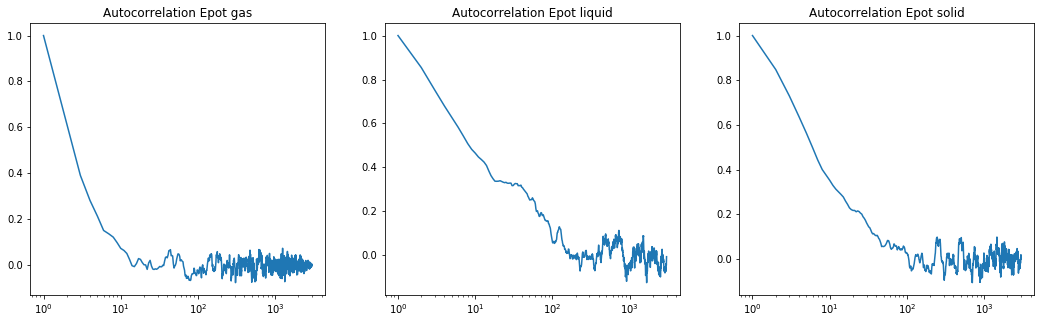

In [17]:
def autocorrelation(v):
    n = len(v)
    var = v.var()
    v = v - v.mean()
    c = np.correlate(v,v,mode='full') [-n:]
    return c / (var*n)

corr_u_g = u_g[0:3000,1]
corr_u_g = autocorrelation(corr_u_g)
corr_u_l = u_l[0:3000,1]
corr_u_l = autocorrelation(corr_u_l)
corr_u_s = u_s[0:3000,1]
corr_u_s = autocorrelation(corr_u_s)

x = np.arange(len(corr_u_g))

plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(x+1,corr_u_g)
plt.title('Autocorrelation Epot gas')
plt.xscale('log')
plt.subplot(1, 3, 2)
plt.plot(x+1,corr_u_l)
plt.title('Autocorrelation Epot liquid')
plt.xscale('log')
plt.subplot(1, 3, 3)
plt.plot(x+1,corr_u_s)
plt.title('Autocorrelation Epot solid')
plt.xscale('log')
plt.show()

I risultati ottenuti mostrano come le autocorrelazioni vadano perse già dopo una distanza di circa $100$ step per le fasi solida e liquida. Nella fase gassosa invece le correlazioni tendono a sparire già dopo 10 step. Sono quindi sufficienti blocchi di lunghezza $\ge 100$ per avere valori medi scorrelati tra di loro per tutte e tre le fasi. I risultati riportati si riferisono unicamente alle energie potenziali, quelli per le pressioni sono pressochè identici e non vengono quindi mostrati. 

Si procede quindi a stimare l'incertezza statistica al variare della lunghezza dei blocchi $L$ delle due grandezze termodinamiche. L'errore viene riportato in unità di Lennard-Jones.

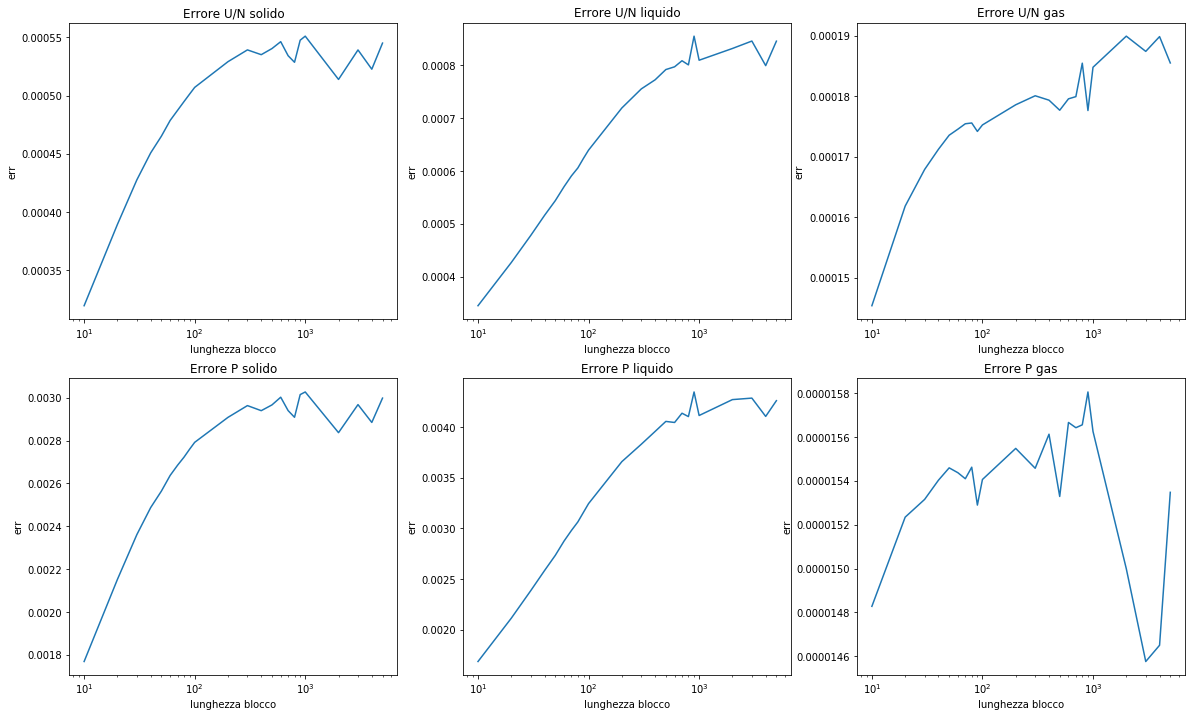

In [4]:
def error(AV,AV2,n):
    if n==0:
        return 0
    else:
        return math.sqrt((AV2 - AV**2)/n)
    
def uncertainty(L,N,x):
    err_prog = np.zeros(len(L))   
    for p in range (len(L)):
        ave = np.zeros(int(N[p]))
        av2 = np.zeros(int(N[p]))
        sum_prog=0
        su2_prog=0
        for i in range(int(N[p])):
            sum = 0
            for j in range(int(L[p])):
                k = j+i*int(L[p])
                sum += x[int(k)]
            ave[i] = sum/int(L[p])      
            av2[i] = (ave[i])**2         
        for j in range(int(N[p])):
            sum_prog += ave[j]
            su2_prog += av2[j] 
        sum_prog/=int(N[p]) 
        su2_prog/=int(N[p]) 
        err_prog[p] = error(sum_prog,su2_prog,int(N[p]))
    return err_prog

L = np.array([10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000])

err_prog_us = uncertainty(L,len(u_s)/L,u_s[:,1])
err_prog_ul = uncertainty(L,len(u_l)/L,u_l[:,1])
err_prog_ug = uncertainty(L,len(u_g)/L,u_g[:,1])
err_prog_ps = uncertainty(L,len(p_s)/L,p_s[:,1])
err_prog_pl = uncertainty(L,len(p_l)/L,p_l[:,1])
err_prog_pg = uncertainty(L,len(p_g)/L,p_g[:,1])

plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
plt.plot(L,err_prog_us)
plt.xscale('log')
plt.title('Errore U/N solido')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')
plt.subplot(2,3,2)
plt.plot(L,err_prog_ul)
plt.xscale('log')
plt.title('Errore U/N liquido')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')
plt.subplot(2,3,3)
plt.plot(L,err_prog_ug)
plt.xscale('log')
plt.title('Errore U/N gas')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')
plt.subplot(2,3,4)
plt.plot(L,err_prog_ps)
plt.xscale('log')
plt.title('Errore P solido')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')
plt.subplot(2,3,5)
plt.plot(L,err_prog_pl)
plt.xscale('log')
plt.title('Errore P liquido')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')
plt.subplot(2,3,6)
plt.plot(L,err_prog_pg)
plt.xscale('log')
plt.title('Errore P gas')
plt.xlabel('lunghezza blocco')
plt.ylabel('err')


plt.show()

I grafici mostrano come l'incertezza aumenti per valori $L < 100$ per poi (approssimativamente) saturare. Il valore ottimale per la lunghezza dei blocchi è quindi stata scelta come $L=200$.

### Esercizio 7.2 
Viene richiesto di implementare nel codice di Monte Carlo NVT una metodo per calcolare la funzione di distribuzione radiale $g(r)$ e di stampare i valori di tale funzione per ogni blocco e il loro valor medio su appositi file. Tali risultati non vengono qui riportati ma vengono discussi all'interno di **Esercizio 7.4**.

### Esercizio 7.3
Viene richiesto di estendere le richieste dell'esercizio precedente al codice di Dinamica Molecolare dell'esercitazione 4. Di nuovo, i risultati sono discussi all'interno di **Esercizio 7.4**.

### Esercizio 7.4 
Considerando un campione di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle medesime condizioni di **Esercizio 7.1**, si richiede di confrontare il codice di Monte Carlo NVT e Dinamica Molecolare NVE valutando energia potenziale media per particella, pressione media e distribuzione radiale nelle tre fasi.

In [2]:
u4_l = np.loadtxt("Lab4/output.epot.liquid.0")
p4_l = np.loadtxt("Lab4/output.pres.liquid.0")
g4_l = np.loadtxt("Lab4/output.gave.liquid.0")

u7_l = np.loadtxt("Lab7/7.4/output.epot.liquid.0")
p7_l = np.loadtxt("Lab7/7.4/output.pres.liquid.0")
g7_l = np.loadtxt("Lab7/7.4/output.gave.liquid.0")

u4_g = np.loadtxt("Lab4/output.epot.gas.0")
p4_g = np.loadtxt("Lab4/output.pres.gas.0")
g4_g = np.loadtxt("Lab4/output.gave.gas.0")

u7_g = np.loadtxt("Lab7/7.4/output.epot.gas.0")
p7_g = np.loadtxt("Lab7/7.4/output.pres.gas.0")
g7_g = np.loadtxt("Lab7/7.4/output.gave.gas.0")

u4_s = np.loadtxt("Lab4/output.epot.solid.0")
p4_s = np.loadtxt("Lab4/output.pres.solid.0")
g4_s = np.loadtxt("Lab4/output.gave.solid.0")

u7_s = np.loadtxt("Lab7/7.4/output.epot.solid.0")
p7_s = np.loadtxt("Lab7/7.4/output.pres.solid.0")
g7_s = np.loadtxt("Lab7/7.4/output.gave.solid.0")

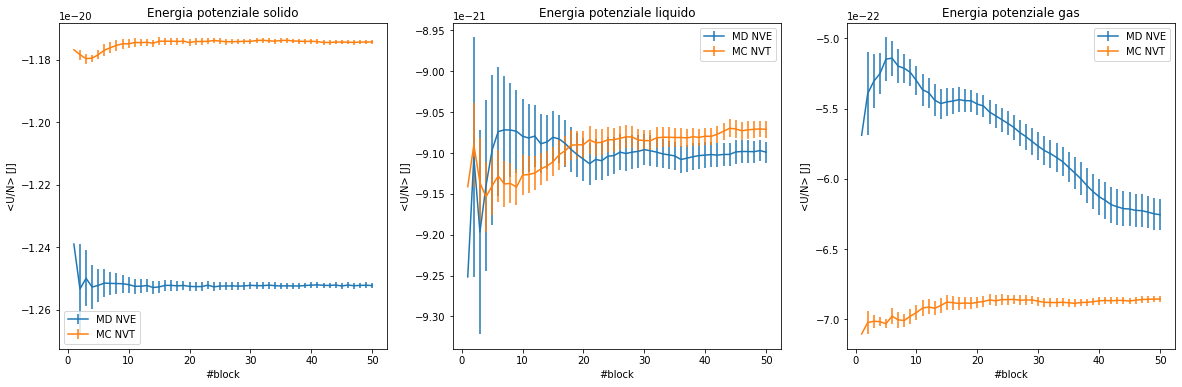

In [27]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.errorbar(u4_s[:,0],u4_s[:,2]*165.6*10**-23,yerr=u4_s[:,3]*165.6*10**-23,label=('MD NVE'))
plt.errorbar(u7_s[:,0],u7_s[:,2]*165.6*10**-23,yerr=u7_s[:,3]*165.6*10**-23,label=('MC NVT'))
plt.title('Energia potenziale solido')
plt.xlabel('#block')
plt.ylabel('<U/N> [J]')
plt.legend()
plt.subplot(1,3,2)
plt.errorbar(u4_l[:,0],u4_l[:,2]*165.6*10**-23,yerr=u4_l[:,3]*165.6*10**-23,label=('MD NVE'))
plt.errorbar(u7_l[:,0],u7_l[:,2]*165.6*10**-23,yerr=u7_l[:,3]*165.6*10**-23,label=('MC NVT'))
plt.title('Energia potenziale liquido')
plt.xlabel('#block')
plt.ylabel('<U/N> [J]')
plt.legend()
plt.subplot(1,3,3)
plt.errorbar(u4_g[:,0],u4_g[:,2]*165.6*10**-23,yerr=u4_g[:,3]*165.6*10**-23,label=('MD NVE'))
plt.errorbar(u7_g[:,0],u7_g[:,2]*165.6*10**-23,yerr=u7_g[:,3]*165.6*10**-23,label=('MC NVT'))
plt.title('Energia potenziale gas')
plt.xlabel('#block')
plt.ylabel('<U/N> [J]')
plt.legend()
plt.show()

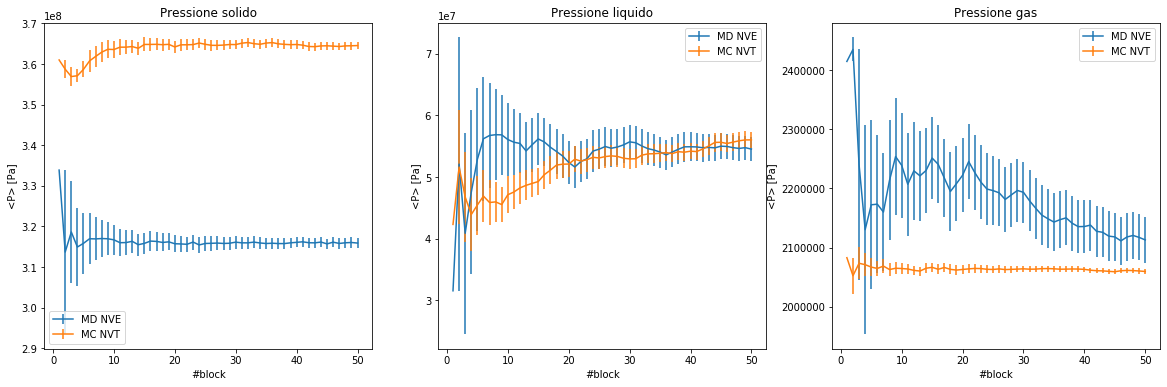

In [29]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.errorbar(p4_s[:,0],p4_s[:,2]*4.213*10**7,yerr=p4_s[:,3]*4.213*10**7,label=('MD NVE'))
plt.errorbar(p7_s[:,0],p7_s[:,2]*4.213*10**7,yerr=p7_s[:,3]*4.213*10**7,label=('MC NVT'))
plt.title('Pressione solido')
plt.xlabel('#block')
plt.ylabel('<P> [Pa]')
plt.legend()
plt.subplot(1,3,2)
plt.errorbar(p4_l[:,0],p4_l[:,2]*4.213*10**7,yerr=p4_l[:,3]*4.213*10**7,label=('MD NVE'))
plt.errorbar(p7_l[:,0],p7_l[:,2]*4.213*10**7,yerr=p7_l[:,3]*4.213*10**7,label=('MC NVT'))
plt.title('Pressione liquido')
plt.xlabel('#block')
plt.ylabel('<P> [Pa]')
plt.legend()
plt.subplot(1,3,3)
plt.errorbar(p4_g[:,0],p4_g[:,2]*4.213*10**7,yerr=p4_g[:,3]*4.213*10**7,label=('MD NVE'))
plt.errorbar(p7_g[:,0],p7_g[:,2]*4.213*10**7,yerr=p7_g[:,3]*4.213*10**7,label=('MC NVT'))
plt.title('Pressione gas')
plt.xlabel('#block')
plt.ylabel('<P> [Pa]')
plt.legend()
plt.show()

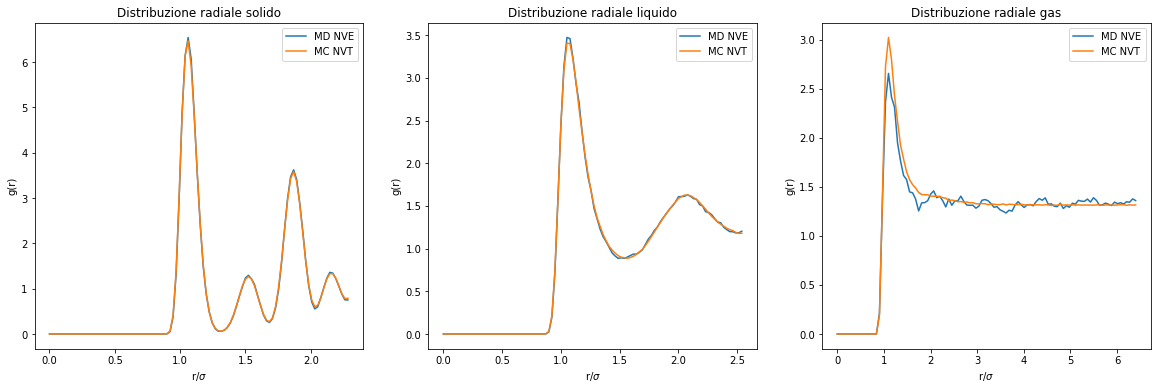

In [26]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.errorbar(g4_s[:,0],g4_s[:,1],label=('MD NVE'))
plt.errorbar(g7_s[:,0],g7_s[:,1],label=('MC NVT'))
plt.title('Distribuzione radiale solido')
plt.xlabel('r/$\sigma$')
plt.ylabel('g(r)')
plt.legend()
plt.subplot(1,3,2)
plt.errorbar(g4_l[:,0],g4_l[:,1],label=('MD NVE'))
plt.errorbar(g7_l[:,0],g7_l[:,1],label=('MC NVT'))
plt.title('Distribuzione radiale liquido')
plt.xlabel('r/$\sigma$')
plt.ylabel('g(r)')
plt.legend()
plt.subplot(1,3,3)
plt.errorbar(g4_g[:,0],g4_g[:,1],label=('MD NVE'))
plt.errorbar(g7_g[:,0],g7_g[:,1],label=('MC NVT'))
plt.title('Distribuzione radiale gas')
plt.xlabel('r/$\sigma$')
plt.ylabel('g(r)')
plt.legend()
plt.show()

I risultati ottenuti mostrano come la distribuzione radiale risulti fondamentalmente la stessa per i due codici in tutte e tre le fasi. Per quanto riguardo energia potenziale e pressione invece si osservano alcune differenze nei valori medi ottenuti. I due codici in effetti si riferiscono ad ensemble termodinamici differenti (microcanonico quello di Dinamica Molecolare e canonico quello Monte Carlo): è quindi plausibile che osservabili termodinamiche abbiano valori medi differenti sui due ensemble.